# Glauber on infinite Erdos-Renyi graph
Compute magnetization in the thermodynamic limit $N\to\infty$ for Erdos-Renyi graphs with average connectivity $c=5$ using population dynamics.

In [2]:
using MatrixProductBP, MatrixProductBP.Models
using Distributions, Statistics, Base.Threads, Plots, LaTeXStrings
using ProgressMeter; ProgressMeter.ijulia_behavior(:clear)
using JLD2;

┌ Info: Precompiling MatrixProductBP [3d39929c-b583-45fa-b331-3f50b693a38a]
└ @ Base loading.jl:1662


In [3]:
T = 15      # final time
c = 4.0     # average degree
m⁰ = -0.6   # magnetization at time zero

β = 1.0
J = 0.5
h = 0.0

popsize = 10^2              # population size
svd_trunc = TruncBond(18);  # SVD truncator

In [4]:
wᵢ = fill(HomogeneousGlauberFactor(J, h, β), T+1)
ϕᵢ = [ t == 0 ? [(1+m⁰)/2, (1-m⁰)/2] : ones(2) for t in 0:T]
ψ_neutral = [ones(2,2) for t in 0:T];

In [5]:
function onebpiter_inner(μ, wᵢ, dᵢ, ns, ϕᵢ, ψ, T, svd_trunc)
    C, full, logzᵢ = MatrixProductBP.Models.compute_prob_ys(wᵢ, ns, μ, ψ, T, svd_trunc)
    for j in 1:dᵢ
        B = MatrixProductBP.Models.f_bp_partial_ij(C[j], wᵢ, ϕᵢ, dᵢ - 1, ns, j)
        μ[j] = sweep_RtoL!(mpem2(B); svd_trunc)
        logzᵢ += normalize!(μ[j])
    end
    B = MatrixProductBP.Models.f_bp_partial_i(full, wᵢ, ϕᵢ, dᵢ)
    b = B |> mpem2 |> marginalize
    f = dᵢ == 0 ? 0.0 : -logzᵢ / dᵢ
    return μ, b, f
end

onebpiter_inner (generic function with 1 method)

In [6]:
function iterate_population!(P, bs, rs, wᵢ, degree_prob, ϕᵢ, T, svd_trunc; nsamples=2*10^2)
    @showprogress for n in 1:nsamples
        d = rand(degree_prob)
        d > popsize && error("Sampled degree $d greater than population size $popsize")
        indices = rand(eachindex(P), d)     
        μ, b, f = onebpiter_inner(P[indices], wᵢ, d, 2, ϕᵢ, fill(ψ_neutral, d), T, svd_trunc)
        P[indices] = μ
        push!(bs, marginals(b))
        push!(rs, marginals_tu(b))
    end
end

iterate_population! (generic function with 1 method)

In [7]:
degree_prob = Poisson(c)
P = map(1:popsize) do p
    μ = rand_mpem2(2, 2, T)
    normalize!(μ)
    μ
end
bs = Vector{Vector{Float64}}[]
btus =  Matrix{Matrix{Float64}}[];

In [ ]:
iterate_population!(P, bs, btus, wᵢ, degree_prob, ϕᵢ, T, svd_trunc; nsamples=2*10^2);

In [ ]:
spin(x) = 3 - 2x
# take the average beliefs over the last `ns` iterations
ns = 200
range = length(bs)+1-min(ns, length(bs)):length(bs)
ms = [expectation.(spin, b) for b in bs[range]]
m_avg = mean(ms)
m_std = std(ms) ./ sqrt(length(ms));

In [ ]:
spin(x) = 3 - 2x
rs = [expectation.(spin, btu) for btu in btus[range]]
cs = MatrixProductBP.covariance.(rs, ms)
c_avg = mean(cs)
c_std = std(cs) ./ sqrt(length(cs));

In [ ]:
plot_autocovs(args...; kw...) = plot_autocovs!(plot(), args...; kw...)
function plot_autocovs!(pl, c; skip_even=false, T=size(c,1)-1, us = 0:(2*floor(Int, T/10)):T, kw...)
    step = skip_even ? 2 : 1
    cg = cgrad(:matter, length(us)+1, categorical=true)
    ylabel = L"\langle x_{i}^t x_{i}^{t+\Delta t}\rangle-" * 
        L"\langle x_{i}^t\rangle\langle x_{i}^{t+\Delta t}\rangle"
    xlabel = L"\Delta t"
    plot!(pl; xlabel, ylabel, legend=:outertopright)
     
    for (j,u) in enumerate(us)
        plot!(pl, u:-step:1, c[(0:step:u-1) .+ 1,u+1], label="t+Δt=$u", c=cg[j+1], msc=:auto; kw...) 
    end
    pl
end 

plot_autocovs(c_avg; skip_even=true, yaxis=:log10, m=:o, us=4:2:T)

In [49]:
using Graphs, IndexedGraphs

seed = 1
N = 5*10^3
g = erdos_renyi(N, c/N; seed)
ising = Ising(IndexedGraph(g); J=fill(J, ne(g)), h=fill(h, N), β)
bp = mpbp(Glauber(ising, T); ϕ = fill(ϕᵢ, N))
sms = SoftMarginSampler(bp);

In [50]:
sample!(sms, 5*10^3)
m_mc = [vec(spin.(mean(X, dims=1))) for X in sms.X];

SoftMargin sampling 100%|████████████████████████████████| Time: 0:02:45


In [29]:
m_eq = equilibrium_magnetization(ErdosRenyi(c); pJ=Dirac(J), β, ph=Dirac(h), popsize=2*10^6,
        maxiter=10^2, tol=1e-6, nsamples=10^4);

Running PopDyn: iter 100 	 Time: 0:02:16
  it:  100/100
  ε:   0.000941/1.0e-6┌ Warning: Population dynamics did not converge. Error 0.0009407583083131943
└ @ MatrixProductBP.Models /home/crotti/MatrixProductBP/src/Models/glauber/equilibrium.jl:105


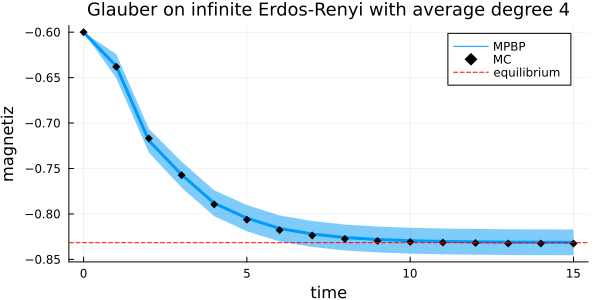

In [51]:
pl = plot(0:T, m_avg, lw=3, ribbon=m_std, xlabel="time", ylabel="magnetiz",
    title="Glauber on infinite Erdos-Renyi with average degree $(Int(c))", titlefontsize=12,
    size = (600,300), label="MPBP")
pl2 = deepcopy(pl)
scatter!(pl2, 0:T, mean(m_mc), label="MC", c=:black, m=:diamond)
pl3 = deepcopy(pl2)
hline!(pl3, [-m_eq.val], label="equilibrium", c=:red, ls=:dash, lw=1, size=(600,300)#=, ribbon=[-m_eq.err]=#)

In [53]:
jldsave("plot_data/glauber_erdos_renyi.jld2"; T, m_mc, m_avg, m_std, m_eq, c_avg, c_std);